In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
import seaborn as sns
from textblob import TextBlob
data = pd.read_csv('data/traficogt.csv')

data['processed_content'] = data['rawContent'].str.lower()

data[['rawContent', 'processed_content']].head()

,rawContent,processed_content
0,"#AHORA Amílcar Montejo, director de Comunicaci...","#ahora amílcar montejo, director de comunicaci..."
1,CONDUCTORA QUE SE NEGÓ A MOVILIZAR VEHÍCULO ES...,conductora que se negó a movilizar vehículo es...
2,Camión de arena volteado en el viaducto el pul...,camión de arena volteado en el viaducto el pul...
3,"Paciente de 39 años, dolor lumbar de 1 año tra...","paciente de 39 años, dolor lumbar de 1 año tra..."
4,"#AHORA Amílcar Montejo, director de Comunicaci...","#ahora amílcar montejo, director de comunicaci..."


In [4]:
data['processed_content'] = data['processed_content'].apply(lambda x: re.sub(r'http\S+', '', x))

data['processed_content'].head()


0    #ahora amílcar montejo, director de comunicaci...
1    conductora que se negó a movilizar vehículo es...
2    camión de arena volteado en el viaducto el pul...
3    paciente de 39 años, dolor lumbar de 1 año tra...
4    #ahora amílcar montejo, director de comunicaci...
Name: processed_content, dtype: object

In [5]:
emoticon_pattern = r'[:;=8][\-^*]?[)\]DP3]'

data['processed_content'] = data['processed_content'].apply(lambda x: re.sub(emoticon_pattern, '', x))

data['processed_content'].head()


0    #ahora amílcar montejo, director de comunicaci...
1    conductora que se negó a movilizar vehículo es...
2    camión de arena volteado en el viaducto el pul...
3    paciente de 39 años, dolor lumbar de 1 año tra...
4    #ahora amílcar montejo, director de comunicaci...
Name: processed_content, dtype: object

In [6]:
nltk.download('stopwords')

spanish_stopwords = stopwords.words('spanish')

data['processed_content'] = data['processed_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in spanish_stopwords]))

data['processed_content'].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


0    #ahora amílcar montejo, director comunicación ...
1    conductora negó movilizar vehículo multada 📍ca...
2    camión arena volteado viaducto pulté hacia hac...
3    paciente 39 años, dolor lumbar 1 año tras caíd...
4    #ahora amílcar montejo, director comunicación ...
Name: processed_content, dtype: object

In [7]:
data['processed_content'] = data['processed_content'].apply(lambda x: re.sub(r'[@#\'\"]', '', x))

data['processed_content'].head()

0    ahora amílcar montejo, director comunicación e...
1    conductora negó movilizar vehículo multada 📍ca...
2    camión arena volteado viaducto pulté hacia hac...
3    paciente 39 años, dolor lumbar 1 año tras caíd...
4    ahora amílcar montejo, director comunicación e...
Name: processed_content, dtype: object

In [8]:
# General Overview
overview = {
    "Number of Rows": len(data),
    "Number of Columns": data.shape[1],
    "Date Range": f"{data['date'].min()} to {data['date'].max()}",
    "Unique Users": data['user'].nunique(),
    "Total Tweets": data['rawContent'].nunique(),
    "Average Words per Tweet": int(data['processed_content'].apply(lambda x: len(x.split())).mean())
}

overview


{'Number of Rows': 12631,
 'Number of Columns': 30,
 'Date Range': '2012-12-26 00:35:35+00:00 to 2023-09-14 19:19:00+00:00',
 'Unique Users': 4789,
 'Total Tweets': 9827,
 'Average Words per Tweet': 16}

Como podemos observar, hay una cantidad de 12,631 tuits, siendo estos de 4,789 usuarios unicos que vienen desde 2012 hasta 2023, habiendo 9,827 tuits unicos. Cada tuit tiene una media de palabras de 16.

In [9]:
missing_values = data.isnull().sum()

missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

missing_values


retweetedTweet      12630
coordinates         12629
place               12226
quotedTweet         11705
inReplyToTweetId     8090
inReplyToUser        7220
viewCount            5394
dtype: int64

De esto podemos ver que no hay tantos retweets en los tweets, la mayoria son unicos. Y una gran parte de estos no tienen data de geolocalizació, cosa que es creible ya que recientemente se elimino la ubicacíon de los tuits. 

C:\Users\javie\AppData\Local\Temp\ipykernel_4052\2931507788.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['date'].dt.to_period('M')


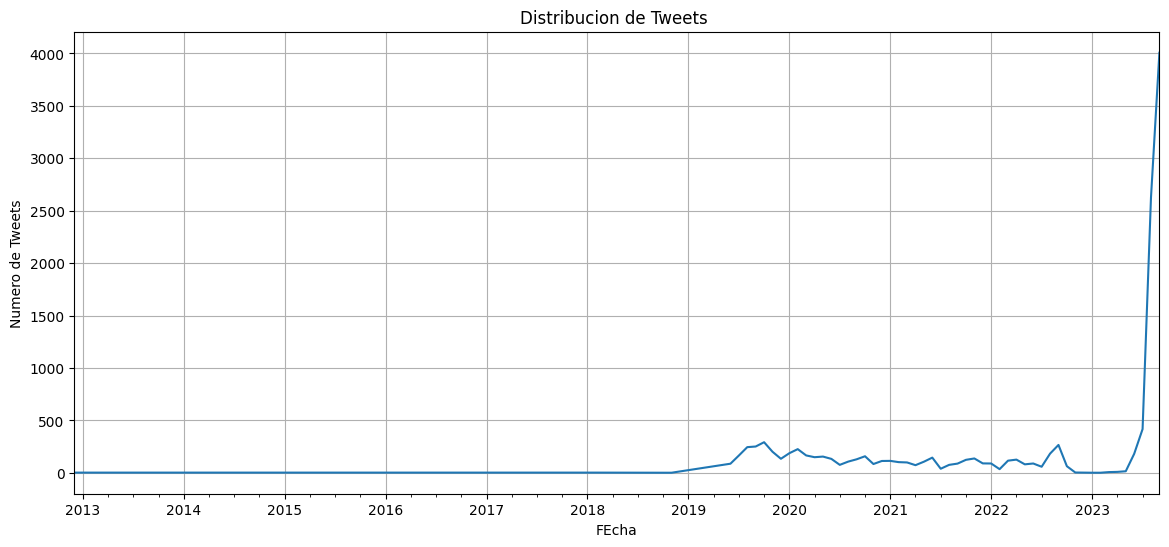

In [10]:
data['date'] = pd.to_datetime(data['date'])

data['year_month'] = data['date'].dt.to_period('M')

tweets_over_time = data.groupby('year_month').size()

tweets_over_time.plot(figsize=(14, 6), title="Distribucion de Tweets ")
plt.xlabel("FEcha")
plt.ylabel("Numero de Tweets")
plt.grid(True)
plt.show()


Como podemos observar, se tiene más datos desde 2023, cosa que se puede deber a que Twitter a aumentado de popularidad recientemente gracias a la adquisicion de la red social por Elon Musk

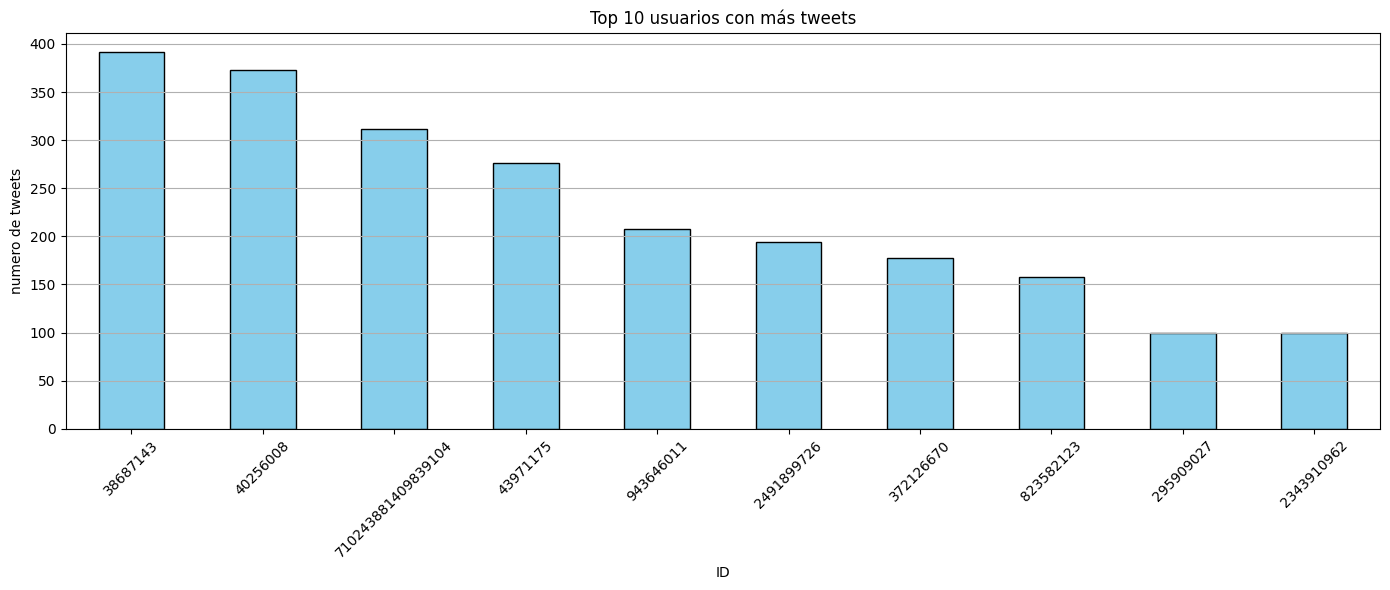

In [11]:
data['user_id'] = data['user'].apply(lambda x: x.split("'id_str': '")[1].split("',")[0])

top_users = data['user_id'].value_counts().head(10)

top_users.plot(kind='bar', figsize=(14, 6), color='skyblue', edgecolor='black')
plt.title("Top 10 usuarios con más tweets")
plt.xlabel("ID")
plt.ylabel("numero de tweets")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Aqui podemos observar los 10 usuarios que más tuits tienen, y esto nos puede servir para poder observar patrones de quien es la cuenta que más hace tuits. 

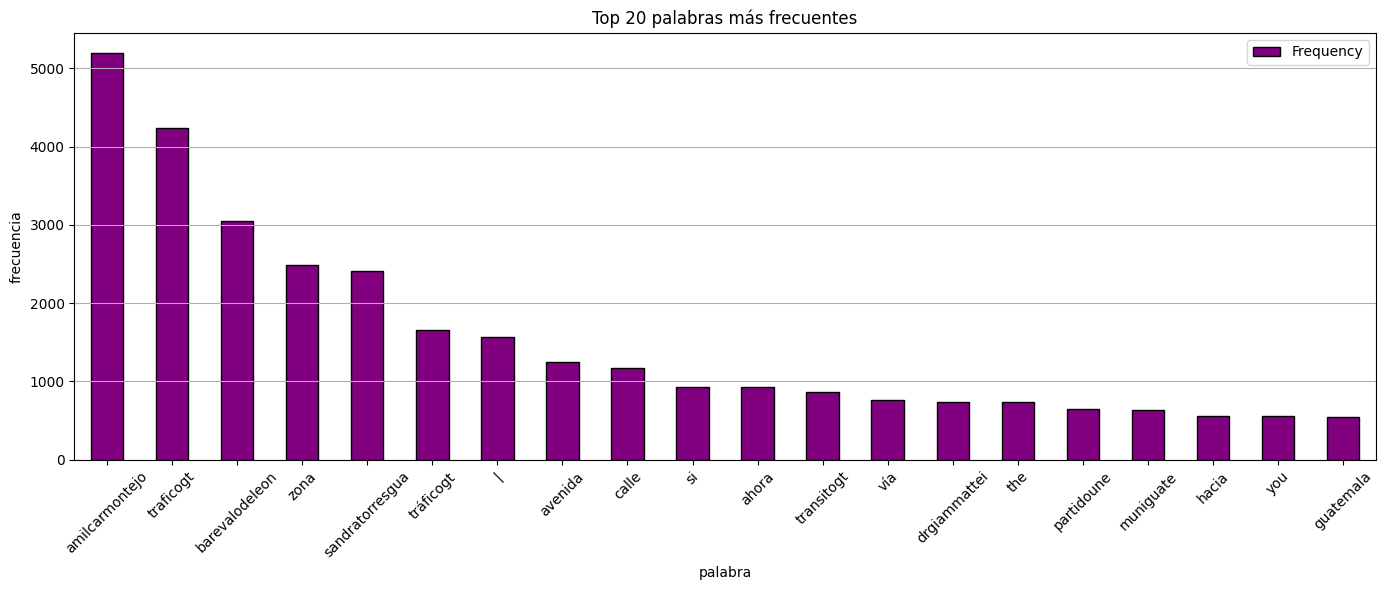

In [12]:
all_words = ' '.join(data['processed_content']).split()

word_freq = Counter(all_words)

top_words = word_freq.most_common(20)
df_top_words = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

df_top_words.set_index('Word').plot(kind='bar', figsize=(14, 6), color='purple', edgecolor='black')
plt.title("Top 20 palabras más frecuentes")
plt.xlabel("palabra")
plt.ylabel("frecuencia")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



Estas son las 20 palabras que más aparecen en los tuits 

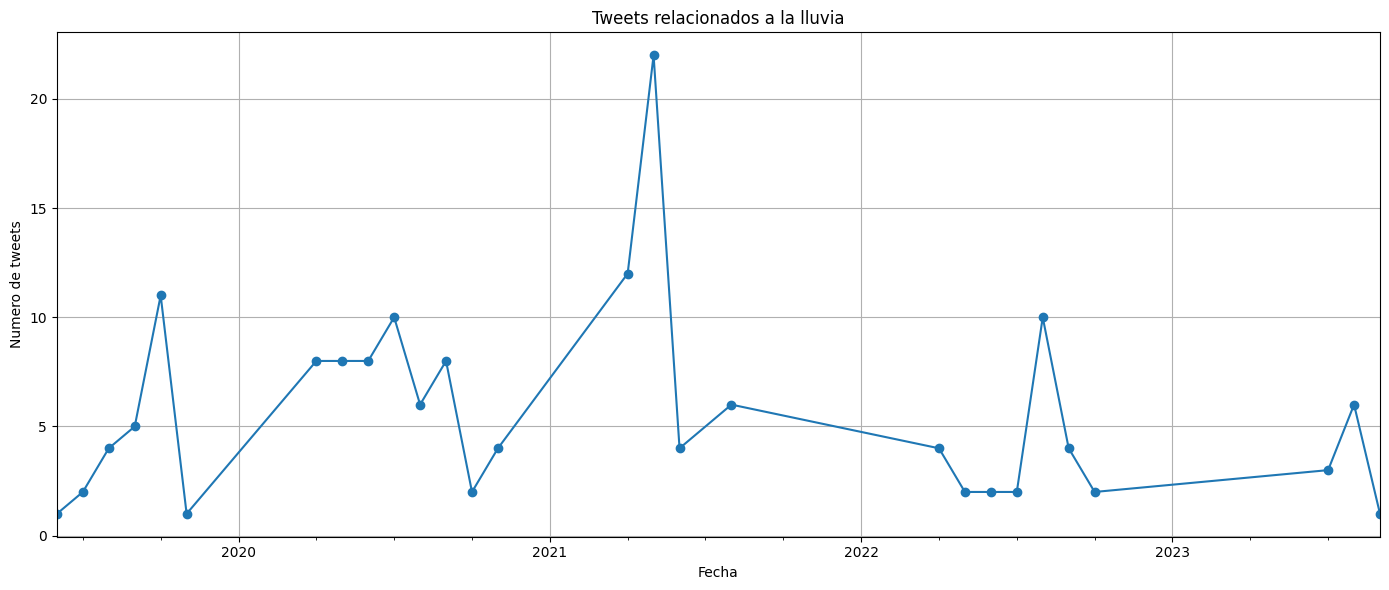

In [13]:
rain_related_terms = ['lluvia', 'lluvioso', 'aguacero', 'tormenta']
rain_tweets = data[data['processed_content'].str.contains('|'.join(rain_related_terms), case=False)]

rain_tweets_per_month = rain_tweets['year_month'].value_counts().sort_index()

rain_tweets_per_month.plot(figsize=(14, 6), title="Tweets relacionados a la lluvia", marker='o')
plt.xlabel("Fecha")
plt.ylabel("Numero de tweets")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
sample_rain_tweets = rain_tweets[['date', 'processed_content']].sample(10)
sample_rain_tweets


,date,processed_content
5980,2020-08-24 21:59:22+00:00,precaución traficogt presencia lluvia zona 10 ...
11427,2022-07-28 18:24:30+00:00,amilcarmontejo muniguate dtransitopnc segundo ...
11141,2021-04-22 15:47:18+00:00,⚠️recuerda llevar☂️ 🌤⛈climagt | nubosidad disp...
10681,2023-07-31 23:39:59+00:00,tráficogt ⚠️🚗🚌| autoridades tránsito informan ...
12213,2020-07-22 20:02:07+00:00,lluvia fuerte granizo zona 7 colonia castillo ...
1002,2023-08-26 19:02:33+00:00,fiscalnvicto cidh pactodecorruptos sandratorre...
8913,2019-09-26 23:37:22+00:00,climagt | amilcarmontejo reporta lluvia avenid...
9913,2019-08-09 20:07:40+00:00,traficogt fuerte lluvia granizo cae zona 1 tom...
11685,2022-04-24 02:20:24+00:00,actualización | lluvias ciudad 🚨☔⛈️ noche repo...
8611,2019-10-08 23:03:35+00:00,[tráficogt] lluvia afecta tránsitogt san josé ...


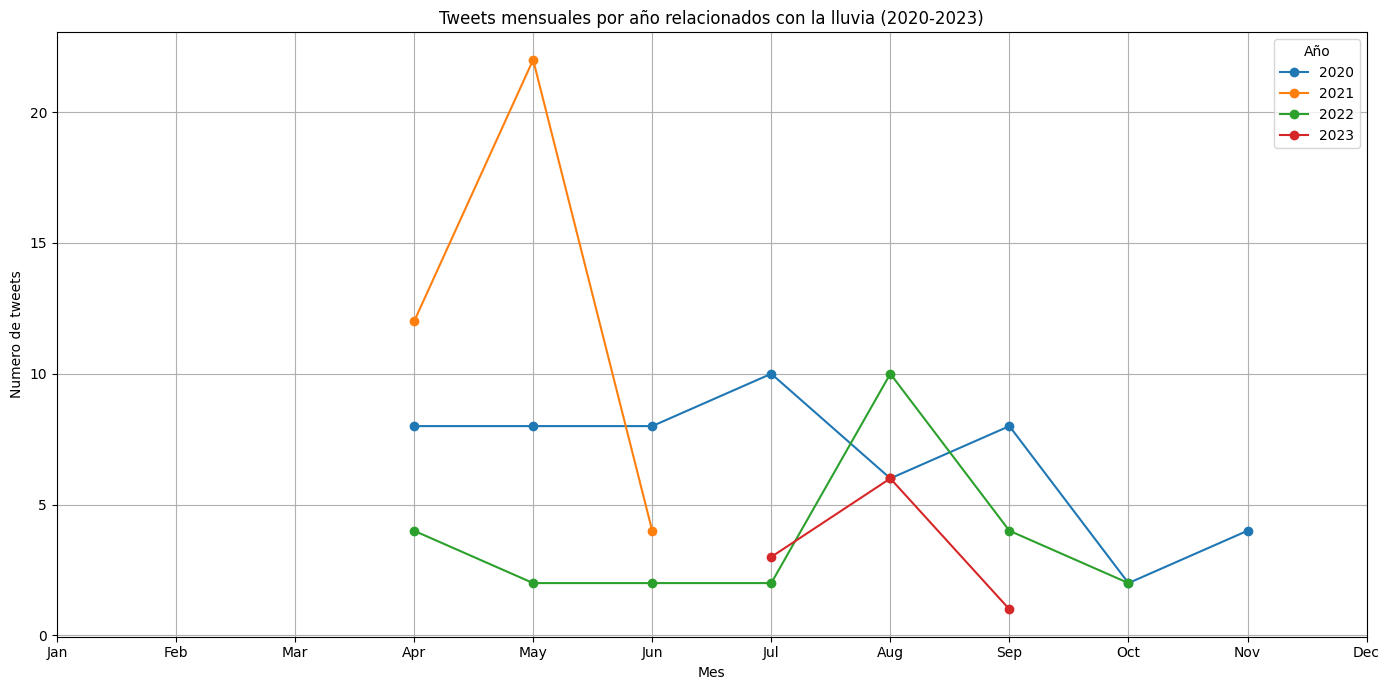

In [15]:
filtered_rain_tweets = rain_tweets[rain_tweets['date'].dt.year.isin([2020, 2021, 2022, 2023])]

monthly_rain_tweets = filtered_rain_tweets.groupby([filtered_rain_tweets['date'].dt.year, filtered_rain_tweets['date'].dt.month]).size().unstack(level=0)

monthly_rain_tweets.plot(figsize=(14, 7), marker='o', title="Tweets mensuales por año relacionados con la lluvia (2020-2023)")
plt.xlabel("Mes")
plt.ylabel("Numero de tweets")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Año")
plt.grid(True)
plt.tight_layout()
plt.show()


# Problema #1: 
## Lluvia y el trafico
Como podemos observar, si se tienen más tweets en los meses de lluvia, como podemos observar en la grafica general y la grafica por años, así como tambien la muestra de tweets, en las tres podemos observar que existen picos en los meses que más lluvia se tiene y esto es relacionado a que normalmente el trafico se incrementa cuando hay lluvia 

In [16]:
socavon_tweets = data[data['processed_content'].str.contains('socavón', case=False) & 
                      data['processed_content'].str.contains('zona 5', case=False) & 
                      data['processed_content'].str.contains('socavon', case=False)]
                        
zona_15_mentions = socavon_tweets['processed_content'].str.contains('zona 15', case=False).sum()

total_socavon_tweets = len(socavon_tweets)
zona_15_mentions, total_socavon_tweets


(0, 0)

In [17]:
socavon_general_tweets = data[data['processed_content'].str.contains('socavon', case=False)]

zona_15_mentions_general = socavon_general_tweets['processed_content'].str.contains('zona 15', case=False).sum()

total_socavon_general_tweets = len(socavon_general_tweets)
zona_15_mentions_general, total_socavon_general_tweets


(0, 0)

In [18]:
hundimiento_tweets = data[data['processed_content'].str.contains('hundimiento', case=False)]

zona_5_mentions_hundimiento = hundimiento_tweets['processed_content'].str.contains('zona 5', case=False).sum()
zona_15_mentions_hundimiento = hundimiento_tweets['processed_content'].str.contains('zona 15', case=False).sum()

total_hundimiento_tweets = len(hundimiento_tweets)
zona_5_mentions_hundimiento, zona_15_mentions_hundimiento, total_hundimiento_tweets


(0, 0, 12)

In [19]:
sample_hundimiento_tweets = hundimiento_tweets[['date', 'processed_content']].sample(min(10, total_hundimiento_tweets))
sample_hundimiento_tweets


,date,processed_content
3003,2022-09-21 18:44:51+00:00,🚨carretera salvador ⎮ vecinos usuarios ruta de...
5630,2020-10-28 12:52:51+00:00,conredguatemala caminos_civ emisorasunidas lfv...
11035,2022-09-21 18:44:51+00:00,🚨carretera salvador ⎮ vecinos usuarios ruta de...
11554,2022-06-14 16:27:52+00:00,"ahora amilcarmontejo, portavoz emetra ciudad g..."
3646,2022-06-14 16:28:09+00:00,"ahora amilcarmontejo, portavoz emetra ciudad g..."
9449,2019-09-02 11:51:10+00:00,"amilcarmontejo buenos días, reportando hundimi..."
3647,2022-06-14 16:27:52+00:00,"ahora amilcarmontejo, portavoz emetra ciudad g..."
2860,2022-10-05 18:36:36+00:00,sé si notaron hundimiento anillo periférico ce...
8577,2019-10-09 12:16:05+00:00,ahora traficogt tomaré ruta x bulevar sur nara...
10919,2022-10-05 18:36:36+00:00,sé si notaron hundimiento anillo periférico ce...


# Problema #1: 
## Socavón y trafico en zona 15

Como podemos observar, realmente no existe una correlación entre los tweets que hablan de un socavón o un hundimiento y los tweets de trafico con respecto a la zona 15, o la zona donde se encuentra la universidad. Si existen bastantes tweets relacionados con hundimientos o socavónes pero ralmente no tienen una correlacion directa con las discusiones de trafico que se tienen con respecto a zona 15. 

# Problema #2: Popularidad Bernardo Arevalo y Sandra Torres. 

In [20]:
sandra_df  = pd.read_csv('data/sandraTorres.csv')
bernardo_df = pd.read_csv('data/bernardoArevalo.csv')

sandra_df.head()
bernardo_df.head()

,Unnamed: 0,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,...,quotedTweet,place,coordinates,inReplyToTweetId,inReplyToUser,source,sourceUrl,sourceLabel,media,_type
0,0,1702109621899407575,1702109621899407575,https://twitter.com/eltuitdehoy_/status/170210...,2023-09-13 23:58:52+00:00,"{'id': 46561608, 'id_str': '46561608', 'url': ...",es,@AnonGTReloaded @msemillagt @BArevalodeLeon ja...,0,0,...,NaN,NaN,NaN,1.702089e+18,"{'id': 1419402501212811265, 'username': 'AnonG...","<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}",snscrape.modules.twitter.Tweet
1,1,1702109505947865192,1702109505947865192,https://twitter.com/totitafuentes/status/17021...,2023-09-13 23:58:24+00:00,"{'id': 1005627722, 'id_str': '1005627722', 'ur...",es,@ASIERVERA @AztecaNoticiaGT @BArevalodeLeon Do...,0,1,...,NaN,NaN,NaN,1.702056e+18,"{'id': 291888009, 'username': 'ASIERVERA', 'di...","<a href=""http://twitter.com/#!/download/ipad"" ...",http://twitter.com/#!/download/ipad,Twitter for iPad,"{'photos': [], 'videos': [], 'animated': []}",snscrape.modules.twitter.Tweet
2,2,1701995859229958189,1701995859229958189,https://twitter.com/DrDavidCabrera/status/1701...,2023-09-13 16:26:49+00:00,"{'id': 743252657083650048, 'id_str': '74325265...",es,"Paciente de 39 años, dolor lumbar de 1 año tra...",2,17,...,NaN,NaN,NaN,NaN,NaN,"<a href=""https://help.twitter.com/en/using-twi...",https://help.twitter.com/en/using-twitter/how-...,advertiser-interface,{'photos': [{'url': 'https://pbs.twimg.com/med...,snscrape.modules.twitter.Tweet
3,3,1702109134387134664,1702109134387134664,https://twitter.com/Fernand0483/status/1702109...,2023-09-13 23:56:55+00:00,"{'id': 1512621569834688513, 'id_str': '1512621...",es,@VicZacariasGT @soy_502 @BArevalodeLeon @msemi...,0,0,...,NaN,NaN,NaN,1.701799e+18,"{'id': 84055675, 'username': 'VicZacariasGT', ...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,{'photos': [{'url': 'https://pbs.twimg.com/med...,snscrape.modules.twitter.Tweet
4,4,1702108943495926143,1702108943495926143,https://twitter.com/MaxTiger502/status/1702108...,2023-09-13 23:56:10+00:00,"{'id': 891058586, 'id_str': '891058586', 'url'...",es,@Igor_Bitkov No le sigan el juego a este ruso ...,1,0,...,NaN,NaN,NaN,1.701898e+18,"{'id': 707086237753090048, 'username': 'Igor_B...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",snscrape.modules.twitter.Tweet


In [21]:
spanish_stopwords = set(stopwords.words('spanish'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[@#\'"]', '', text)
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
    text = ' '.join(word for word in text.split() if word not in spanish_stopwords)
    return text

bernardo_df['processedContent'] = bernardo_df['rawContent'].apply(preprocess_text)
sandra_df['processedContent'] = sandra_df['rawContent'].apply(preprocess_text)

bernardo_processed_head = bernardo_df[['rawContent', 'processedContent']].head()
sandra_processed_head = sandra_df[['rawContent', 'processedContent']].head()

bernardo_processed_head, sandra_processed_head

(                                          rawContent  \
 0  @AnonGTReloaded @msemillagt @BArevalodeLeon ja...   
 1  @ASIERVERA @AztecaNoticiaGT @BArevalodeLeon Do...   
 2  Paciente de 39 años, dolor lumbar de 1 año tra...   
 3  @VicZacariasGT @soy_502 @BArevalodeLeon @msemi...   
 4  @Igor_Bitkov No le sigan el juego a este ruso ...   
 
                                     processedContent  
 0  anongtreloaded msemillagt barevalodeleon jajaj...  
 1  asiervera aztecanoticiagt barevalodeleon dos v...  
 2  paciente 39 años, dolor lumbar 1 año tras caíd...  
 3  viczacariasgt soy_502 barevalodeleon msemillag...  
 4  igor_bitkov sigan juego ruso invasor enero sol...  ,
                                           rawContent  \
 0  @bernardosilvagt @BArevalodeLeon @DrGiammattei...   
 1  @_awskl @mjcabrerar @BArevalodeLeon @TSEGuatem...   
 2  The 2023 National Race Walking Championship &a...   
 3  @Palomin17772524 @mjcabrerar @BArevalodeLeon @...   
 4  @ASolaresM @Mike051270 @BAreva

In [22]:
bernardo_info = bernardo_df[['processedContent', 'replyCount', 'retweetCount']].describe()

sandra_info = sandra_df[['processedContent', 'replyCount', 'retweetCount']].describe()

bernardo_info, sandra_info

(        replyCount  retweetCount
 count  4212.000000   4212.000000
 mean     28.675214     53.502137
 std     283.795014    451.659694
 min       0.000000      0.000000
 25%       0.000000      0.000000
 50%       0.000000      0.000000
 75%       1.000000      1.000000
 max    8609.000000  13093.000000,
         replyCount  retweetCount
 count  5784.000000   5784.000000
 mean     19.563797     38.411307
 std     203.854820    341.966503
 min       0.000000      0.000000
 25%       0.000000      0.000000
 50%       0.000000      0.000000
 75%       1.000000      1.000000
 max    8610.000000  13099.000000)

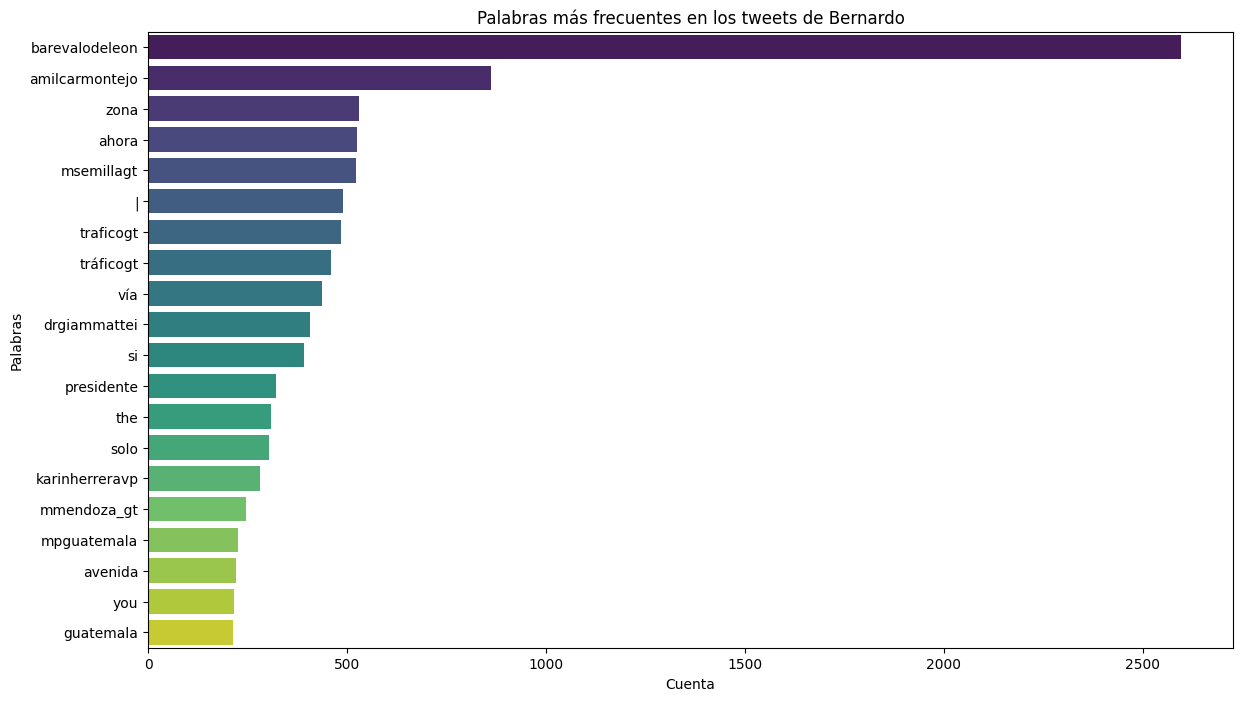

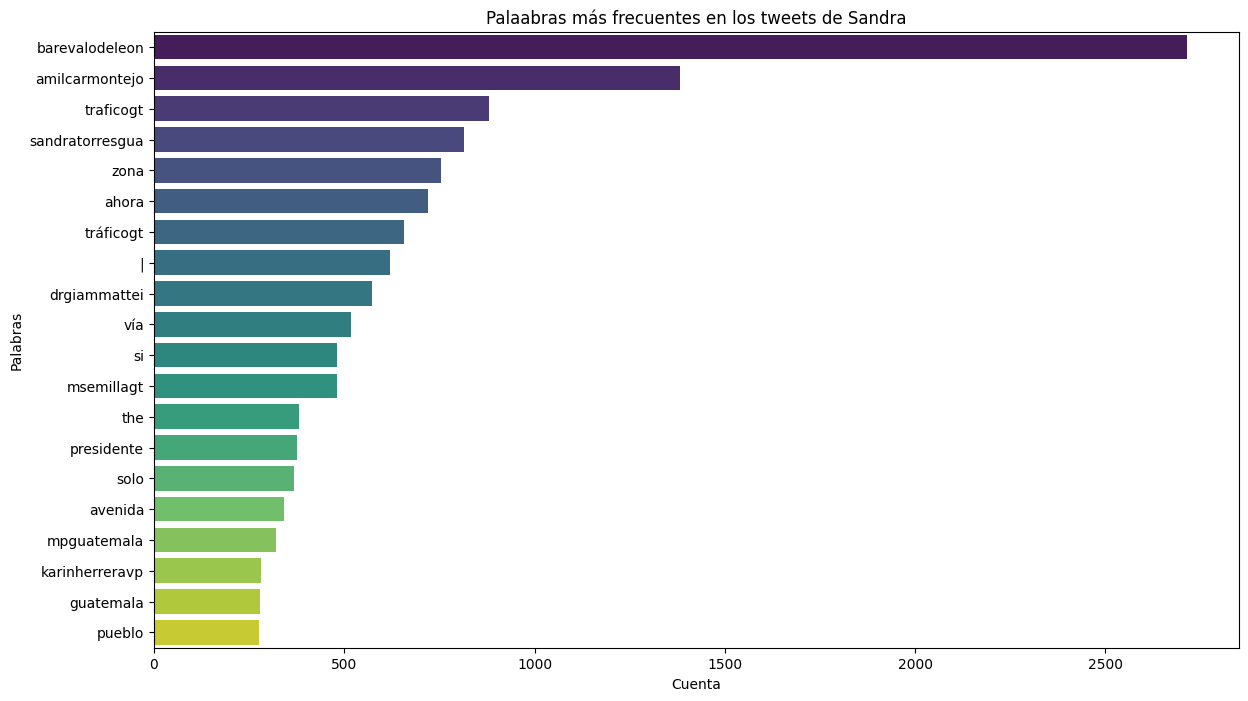

In [28]:
def plot_most_frequent_words(df, column_name, title, n=20):
    all_words = ' '.join(df[column_name]).split()
    
    word_freq = Counter(all_words)
    
    common_words = word_freq.most_common(n)
    
    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]
    
    plt.figure(figsize=(14,8))
    sns.barplot(x=counts, y=words, palette="viridis")
    plt.title(title)
    plt.xlabel('Cuenta')
    plt.ylabel('Palabras')
    plt.show()

plot_most_frequent_words(bernardo_df, 'processedContent', 'Palabras más frecuentes en los tweets de Bernardo')
plot_most_frequent_words(sandra_df, 'processedContent', 'Palaabras más frecuentes en los tweets de Sandra')

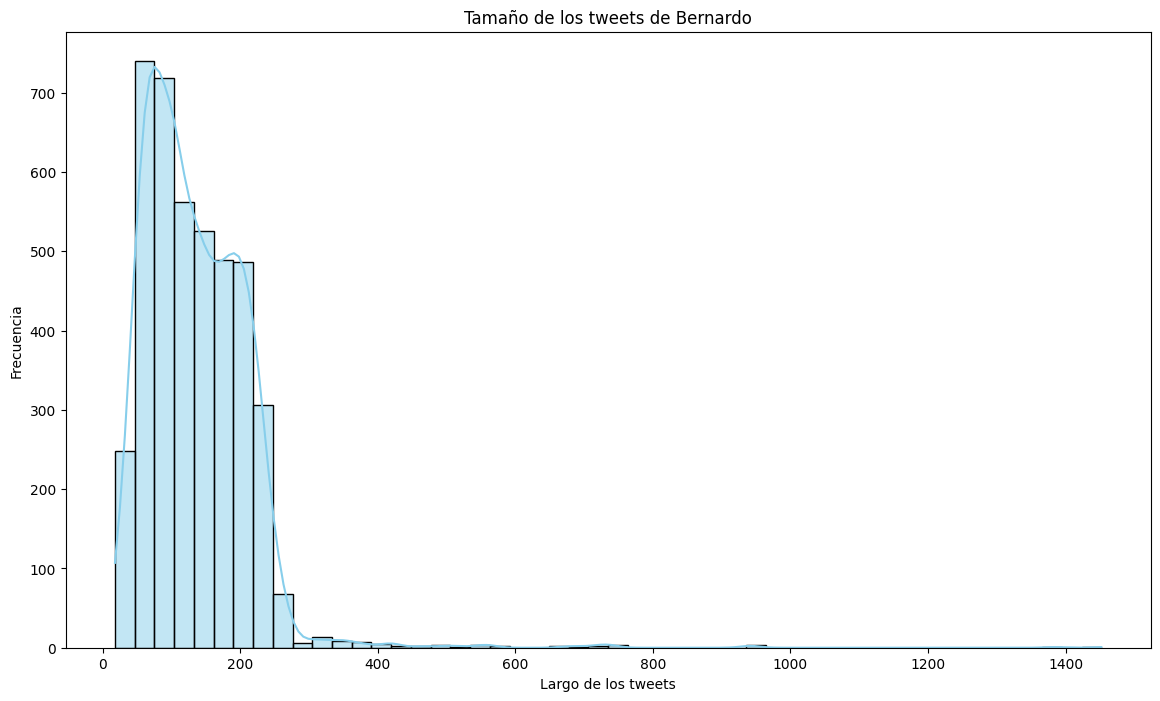

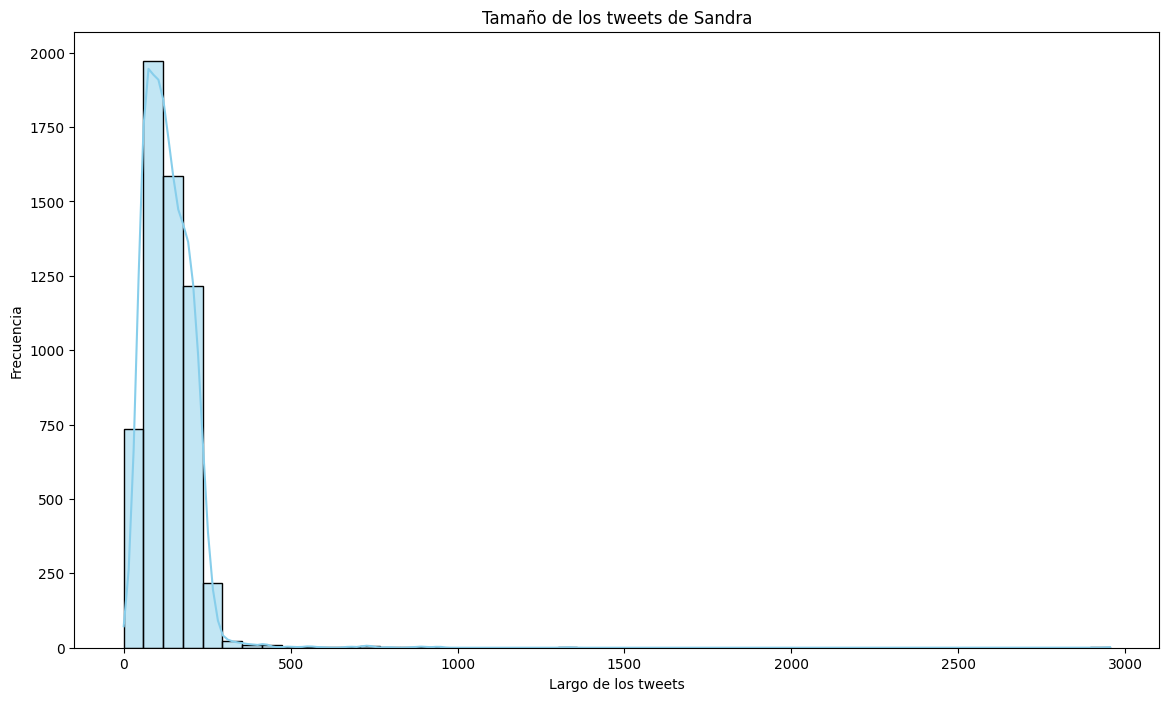

In [27]:
def plot_tweet_length_distribution(df, column_name, title):
    tweet_lengths = df[column_name].apply(len)
    
    plt.figure(figsize=(14,8))
    sns.histplot(tweet_lengths, kde=True, bins=50, color='skyblue')
    plt.title(title)
    plt.xlabel('Largo de los tweets')
    plt.ylabel('Frecuencia')
    plt.show()

plot_tweet_length_distribution(bernardo_df, 'processedContent', 'Tamaño de los tweets de Bernardo')
plot_tweet_length_distribution(sandra_df, 'processedContent', 'Tamaño de los tweets de Sandra')


In [35]:
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

bernardo_df['sentiment'] = bernardo_df['processedContent'].apply(get_textblob_sentiment)
sandra_df['sentiment'] = sandra_df['processedContent'].apply(get_textblob_sentiment)

bernardo_sentiment_dist = bernardo_df['sentiment'].value_counts(normalize=True) * 100
sandra_sentiment_dist = sandra_df['sentiment'].value_counts(normalize=True) * 100

print("Tweets de Bernardo","\n", bernardo_sentiment_dist)


print("Tweets de Sandra", "\n",sandra_sentiment_dist)




Tweets de Bernardo 
 neutral     89.529915
positive     8.926876
negative     1.543210
Name: sentiment, dtype: float64
Tweets de Sandra 
 neutral     91.026971
positive     7.503458
negative     1.469571
Name: sentiment, dtype: float64
